In [1]:
# location of the data files
import os
from models.VAE import VariationalAutoencoder
from models.VAE import CustomCallback
from models.VAE import step_decay_schedule
import matplotlib.pyplot as plt

In [2]:
# run params
SECTION = 'vae_sv'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])
RUN_FOLDER = os.path.join("C:\Projekte\dev\git\Masterarbeit", RUN_FOLDER)
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz_sv'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images_sv'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights_sv'))

mode =  'build' #'load' 

In [3]:
RUN_FOLDER

'C:\\Projekte\\dev\\git\\Masterarbeit\\run/vae_sv/0002_digits'

In [4]:
from models.VAE import VariationalAutoencoder
vae_sv = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2                                  # dimension of latent space
)

if mode == 'build':
    RUN_FOLDER = 'run/vae_sv/0002_digits/viz_sv/viz'
    vae_sv.save(RUN_FOLDER)
else:
    vae_sv.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [5]:
vae_sv.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [6]:
vae_sv.decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

In [8]:
from io import StringIO
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

dat = np.loadtxt('HestonTrainSet_ivol.txt')     # train on prices/implied volatilities
NModelPar = 5                                    # number of model parameters 5 for Heston

yy=dat[:len(dat),:NModelPar]                             # model parameters for training data
xx=dat[:len(dat),NModelPar:]                             # output data (prices/implied volatilities)
print(xx.shape)
print(yy.shape)

strikes=np.array([0.500000000000000, 0.537037037037037, 0.574074074074074, 0.611111111111111, 0.648148148148148, 
                  0.685185185185185, 0.722222222222222, 0.759259259259259, 0.796296296296296, 0.833333333333333,
                  0.870370370370370, 0.907407407407407, 0.944444444444444, 0.981481481481481, 1.01851851851852,
                  1.05555555555556,  1.09259259259259,  1.12962962962963,  1.16666666666667, 1.20370370370370,
                  1.24074074074074, 1.27777777777778, 1.31481481481481, 1.35185185185185,   1.38888888888889,
                  1.42592592592593, 1.46296296296296, 1.50000000000000]) # moneyness

maturities=np.array([0.500000, 0.851852, 1.203704, 1.555556, 1.907407, 2.259259, 2.611111, 2.962963, 3.314815, 
                     3.666667,4.018519, 4.370370, 4.722222, 5.074074, 5.425926, 5.777778, 6.129630, 6.481481, 
                     6.833333, 7.185185, 7.537037, 7.888889, 8.240741, 8.592593, 8.944444, 9.296296, 9.648148,
                     10.000000]) # maturities
weights = np.array([0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,0.1,0.1,0.1])
cw = np.ndarray.flatten(npm.repmat(weights,8,1))

(100000, 784)
(100000, 5)


In [9]:
# does scaling makes sense here?
from sklearn.preprocessing import StandardScaler
scalex = StandardScaler()

xx_transform = scalex.fit_transform(xx)

In [10]:
from sklearn.model_selection import train_test_split
x_train_scaled, x_test_scaled, x_train,x_test,y_train, y_test = train_test_split(
    xx_transform, xx, yy, test_size=0.15, random_state=42)  # test_size is the percentage used for validation/test

# the quantities are scaled now!

In [11]:
# define suitable scalings for using with the nets

def xinversetransform(x):
    return scalex.inverse_transform(x)

def yinversetransform(y):
    return scaley.inverse_transform(y)

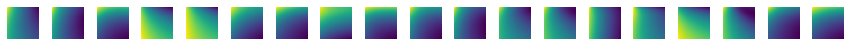

In [12]:
n_to_show = 19
example_idx = np.random.choice(range(len(x_test)), n_to_show)
testsurf = np.reshape(xx,(len(xx),28,28,1))
example_surface = testsurf[example_idx]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_surface[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')

            
    sub.imshow(img)

C:\Users\staeding\AppData\Local\Temp/ipykernel_5436/1678104906.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


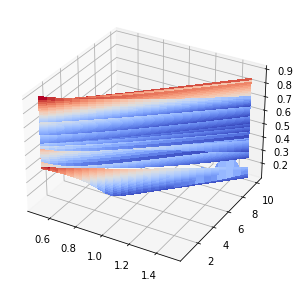

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(5, 5))

ax = fig.gca(projection='3d')
for i in range(n_to_show):
    ax.plot_surface(strikes, maturities, testsurf[i,:,:,0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

sub.imshow(img, cmap='gray_r')

In [14]:
import numpy as np
outfile_train_x_scaled = "x_train_sv_kappanu_scaled"
outfile_test_x_scaled = "x_test_sv_kappanu_scaled"
outfile_train_x = "x_train_sv_kappanu"
outfile_test_x = "x_test_sv_kappanu"
outfile_train_y = "y_train_sv_kappanu"
outfile_test_y = "y_test_sv_kappanu"

np.savetxt(outfile_train_x_scaled, xinversetransform(x_train_scaled))
np.savetxt(outfile_test_x_scaled, xinversetransform(x_test_scaled))
np.savetxt(outfile_train_x, x_train)
np.savetxt(outfile_test_x, x_test)
# these are just the Heston parameters that may be used for further analysis
np.savetxt(outfile_train_y, y_train)
np.savetxt(outfile_test_y, y_test)


In [15]:
# reshape for using with a cnn within the autoencoder
x_train_scaled_reshape = np.reshape(x_train_scaled,(len(x_train),28,28,1))
x_test_scaled_reshape = np.reshape(x_test_scaled,(len(x_test),28,28,1))

x_train_reshape = np.reshape(x_train,(len(x_train),28,28,1))
x_test_reshape = np.reshape(x_test,(len(x_test),28,28,1))

# Start 

In [16]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1

In [17]:
vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=1.0, beta=1.0)

#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.0, beta=1.0)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.1, beta=0.9)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.3, beta=0.7)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.5, beta=0.5)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.7, beta=0.3)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.9, beta=0.1)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=1.0, beta=0.0)

In [18]:
BATCH_SIZE = 32
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [19]:
# maybe not choose the scaled variables but just x_train
#vae_sv.train(     
#    x_train_scaled_reshape
#    , batch_size = BATCH_SIZE
#    , epochs = EPOCHS
#    , run_folder = RUN_FOLDER
#    , print_every_n_batches = PRINT_EVERY_N_BATCHES
#    , initial_epoch = INITIAL_EPOCH
#)
#
vae_sv.train(     
    x_train_reshape
    , batch_size = BATCH_SIZE
   , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Train on 85000 samples
Epoch 1/100
   96/85000 [..............................] - ETA: 5:42 - loss: 0.0356 - vae_r_loss: 0.0330 - vae_kl_loss: 0.0025

C:\Users\staeding\Anaconda3\lib\site-packages\keras\engine\training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


85000/85000 [==============================] - ETA: 0s - loss: 0.0222 - vae_r_loss: 0.0222 - vae_kl_loss: 4.6393e-06
Epoch 00001: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-001-0.02.h5

Epoch 00001: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
85000/85000 [==============================] - 135s 2ms/sample - loss: 0.0222 - vae_r_loss: 0.0222 - vae_kl_loss: 4.6393e-06
Epoch 2/100
84992/85000 [============================>.] - ETA: 0s - loss: 0.0222 - vae_r_loss: 0.0222 - vae_kl_loss: 1.7611e-07
Epoch 00002: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-002-0.02.h5

Epoch 00002: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
85000/85000 [==============================] - 134s 2ms/sample - loss: 0.0222 - vae_r_loss: 0.0222 - vae_kl_loss: 1.7611e-07
Epoch 3/100
84992/85000 [============================>.] - ETA: 0s - loss: 0.0222 - vae_r_loss: 0.0222 - vae_kl_loss: 1.1399e-07
Epoch 00003: saving model t

84992/85000 [============================>.] - ETA: 0s - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 2.4921e-08
Epoch 00039: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-039-0.02.h5

Epoch 00039: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
85000/85000 [==============================] - 132s 2ms/sample - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 2.4926e-08
Epoch 40/100
84992/85000 [============================>.] - ETA: 0s - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 1.7141e-08
Epoch 00040: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-040-0.02.h5

Epoch 00040: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
85000/85000 [==============================] - 133s 2ms/sample - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 1.7142e-08
Epoch 41/100
85000/85000 [==============================] - ETA: 0s - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 5.0546e-08
Epoch 00041: saving model

85000/85000 [==============================] - ETA: 0s - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 4.1499e-08
Epoch 00077: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-077-0.02.h5

Epoch 00077: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
85000/85000 [==============================] - 132s 2ms/sample - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 4.1499e-08
Epoch 78/100
84992/85000 [============================>.] - ETA: 0s - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 2.6443e-08
Epoch 00078: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-078-0.02.h5

Epoch 00078: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
85000/85000 [==============================] - 131s 2ms/sample - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 2.6442e-08
Epoch 79/100
84992/85000 [============================>.] - ETA: 0s - loss: 0.0221 - vae_r_loss: 0.0221 - vae_kl_loss: 4.8082e-08
Epoch 00079: saving model

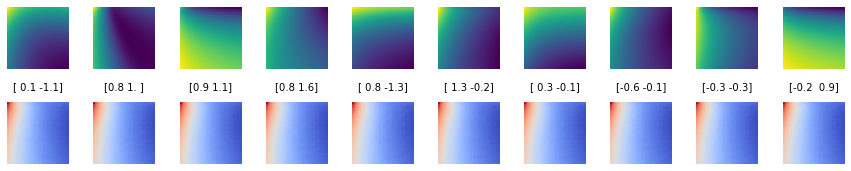

In [20]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)  # generate random id
example_surface = x_test[example_idx]                          # surface
#example_surface_scaled = x_test_scaled[example_idx]            # surface from scaled data

example_surface = np.reshape(example_surface,(len(example_surface),28,28,1))
#example_surface_scaled = np.reshape(example_surface_scaled,(len(example_surface_scaled),28,28,1))

z_points = vae_sv.encoder.predict(example_surface)               # vae generated latent space representation
#z_points_scaled = vae_sv.encoder.predict(example_surface_scaled) # vae generated latent space representation

reconst_images = vae_sv.decoder.predict(z_points)                # vae generated surface 
#reconst_images_scaled = vae_sv.decoder.predict(z_points_scaled)  # vae generated surface
#reconst_images_rescaled = xinversetransform(reconst_images_scaled) # need to backtransform

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_surface[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)         
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='coolwarm')#gray_r')
    
#for i in range(n_to_show):
#    img = reconst_images_scaled[i].squeeze()
#    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
#    sub.axis('off')
#    sub.imshow(img, cmap='coolwarm')#gray_r')
fig.savefig('Rek_VAE') 

    epoch      loss      lr   vae_kl_loss  vae_r_loss
0       0  0.022227  0.0005  4.639345e-06    0.022222
1       1  0.022152  0.0005  1.761075e-07    0.022152
2       2  0.022150  0.0005  1.139799e-07    0.022150
3       3  0.022140  0.0005  6.103095e-08    0.022140
4       4  0.022134  0.0005  1.472578e-07    0.022134
..    ...       ...     ...           ...         ...
95     95  0.022117  0.0005  1.162957e-08    0.022117
96     96  0.022117  0.0005  7.758771e-09    0.022117
97     97  0.022118  0.0005  3.598017e-09    0.022118
98     98  0.022119  0.0005  1.262216e-08    0.022119
99     99  0.022119  0.0005  5.320766e-08    0.022119

[100 rows x 5 columns]


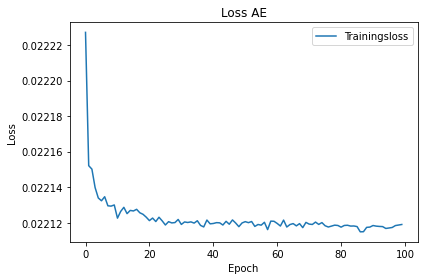

In [39]:
import pandas as pd
df = pd.read_csv('log.csv', sep=';')
print(df)

# plot
plt.figure()
plt.plot(df['epoch'], df['loss'], ls='-')
plt.title('Loss AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Trainingsloss'])
plt.savefig('LossVAE.png')
plt.tight_layout()

    epoch      loss      lr   vae_kl_loss  vae_r_loss
3       3  0.022140  0.0005  6.103095e-08    0.022140
4       4  0.022134  0.0005  1.472578e-07    0.022134
5       5  0.022132  0.0005  6.728698e-08    0.022132
6       6  0.022135  0.0005  7.106171e-08    0.022135
7       7  0.022130  0.0005  1.568885e-07    0.022129
..    ...       ...     ...           ...         ...
95     95  0.022117  0.0005  1.162957e-08    0.022117
96     96  0.022117  0.0005  7.758771e-09    0.022117
97     97  0.022118  0.0005  3.598017e-09    0.022118
98     98  0.022119  0.0005  1.262216e-08    0.022119
99     99  0.022119  0.0005  5.320766e-08    0.022119

[97 rows x 5 columns]


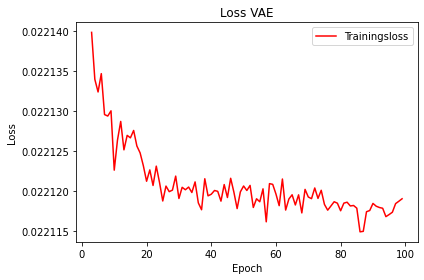

In [22]:
# without the first three rows
import pandas as pd
df = pd.read_csv('log.csv', sep=';')
df = df.drop([0], axis=0)
df = df.drop([1], axis=0)
df = df.drop([2], axis=0)
print(df)

# plot
plt.figure()
plt.plot(df['epoch'], df['loss'], ls='-', color='red')
plt.title('Loss VAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('LossVAE.png')
plt.legend(['Trainingsloss'])
plt.tight_layout()

    epoch      loss      lr   vae_kl_loss  vae_r_loss
0       0  0.022227  0.0005  4.639345e-06    0.022222
1       1  0.022152  0.0005  1.761075e-07    0.022152
2       2  0.022150  0.0005  1.139799e-07    0.022150
3       3  0.022140  0.0005  6.103095e-08    0.022140
4       4  0.022134  0.0005  1.472578e-07    0.022134
..    ...       ...     ...           ...         ...
95     95  0.022117  0.0005  1.162957e-08    0.022117
96     96  0.022117  0.0005  7.758771e-09    0.022117
97     97  0.022118  0.0005  3.598017e-09    0.022118
98     98  0.022119  0.0005  1.262216e-08    0.022119
99     99  0.022119  0.0005  5.320766e-08    0.022119

[100 rows x 5 columns]


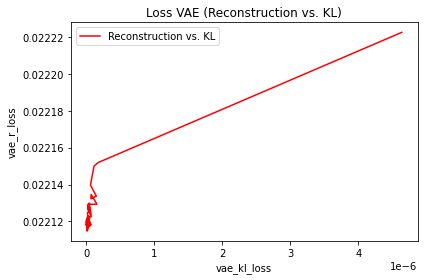

In [23]:
import pandas as pd
df = pd.read_csv('log.csv', sep=';')
print(df)

#plot
plt.figure()
plt.plot(df['vae_kl_loss'],df['vae_r_loss'], ls='-', color='red')
plt.title('Loss VAE (Reconstruction vs. KL)')
plt.xlabel('vae_kl_loss')
plt.ylabel('vae_r_loss')
plt.savefig('LossVAE_RE_KL.png')
plt.legend(['Reconstruction vs. KL'])
plt.tight_layout()

    epoch      loss      lr   vae_kl_loss  vae_r_loss
90     90  0.022118  0.0005  4.855675e-09    0.022118
91     91  0.022118  0.0005  4.000524e-09    0.022118
92     92  0.022118  0.0005  6.352102e-08    0.022118
93     93  0.022118  0.0005  7.480382e-09    0.022118
94     94  0.022117  0.0005  1.562133e-08    0.022117
95     95  0.022117  0.0005  1.162957e-08    0.022117
96     96  0.022117  0.0005  7.758771e-09    0.022117
97     97  0.022118  0.0005  3.598017e-09    0.022118
98     98  0.022119  0.0005  1.262216e-08    0.022119
99     99  0.022119  0.0005  5.320766e-08    0.022119


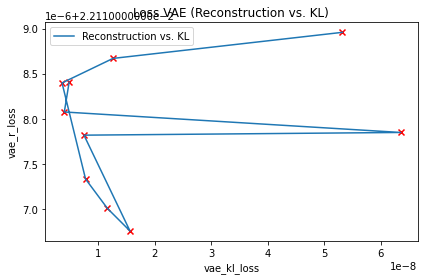

In [37]:
# with a smaller range
import pandas as pd
df = pd.read_csv('log.csv', sep=';')
print(df[90:100])

#plot
plt.figure()
plt.plot(df['vae_kl_loss'][90:100],df['vae_r_loss'][90:100], ls='-')
plt.scatter(df['vae_kl_loss'][90:100],df['vae_r_loss'][90:100], marker='x', facecolors='red')

plt.title('Loss VAE (Reconstruction vs. KL)')
plt.xlabel('vae_kl_loss')
plt.ylabel('vae_r_loss')
plt.savefig('LossVAE_RE_KL_weniger.png')
plt.legend(['Reconstruction vs. KL'])
plt.tight_layout()

# Analysis starts here

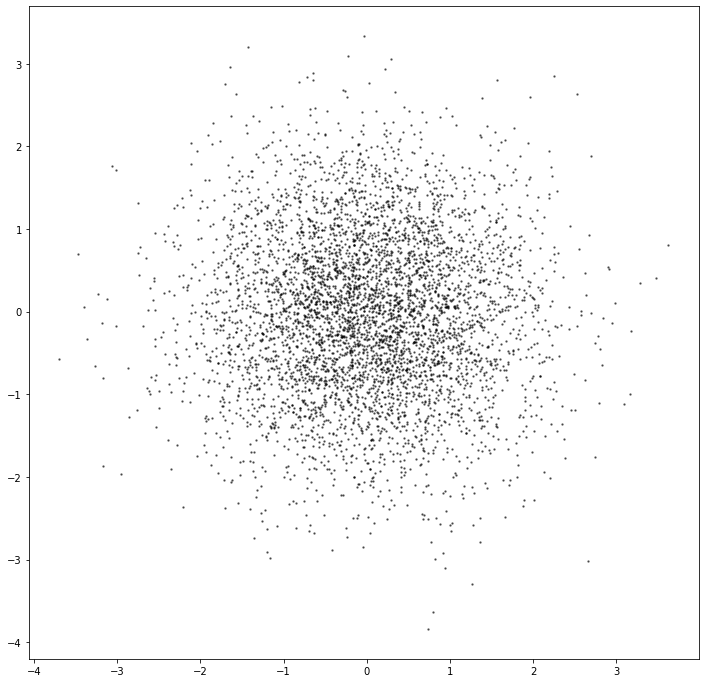

In [26]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae_sv.encoder.predict(x_test_scaled_reshape[example_idx])
#z_points = vae_sv.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plot = plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()
fig = plot.get_figure()
fig.savefig('LatentSpace.png')

C:\Users\staeding\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


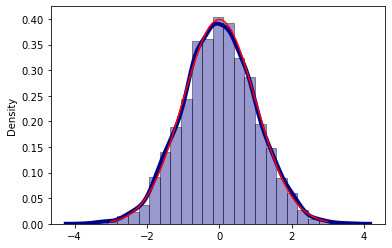

In [27]:
import seaborn as sns
import scipy.stats as stats
plot = sns.distplot(z_points[:, 0], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
x = np.linspace(0 - 3*1, 0 + 3*1, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), color='red')
fig = plot.get_figure()
fig.savefig('LatentSpace1_NormalDist') 

C:\Users\staeding\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


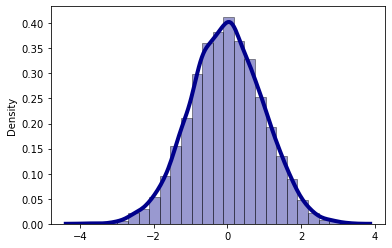

In [28]:
plot = sns.distplot(z_points[:, 1], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig = plot.get_figure()
fig.savefig('LatentSpace2_NormalDist') 

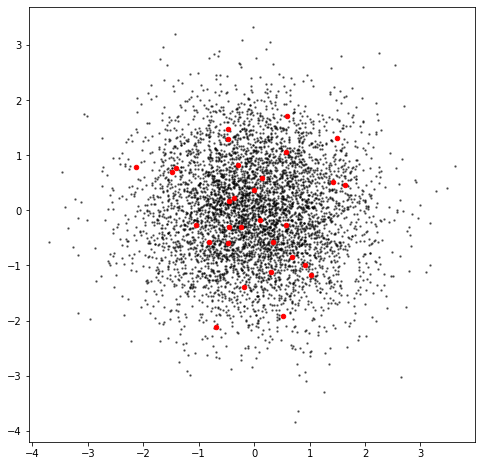

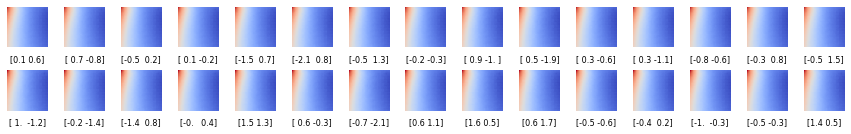

In [29]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae_sv.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'coolwarm')


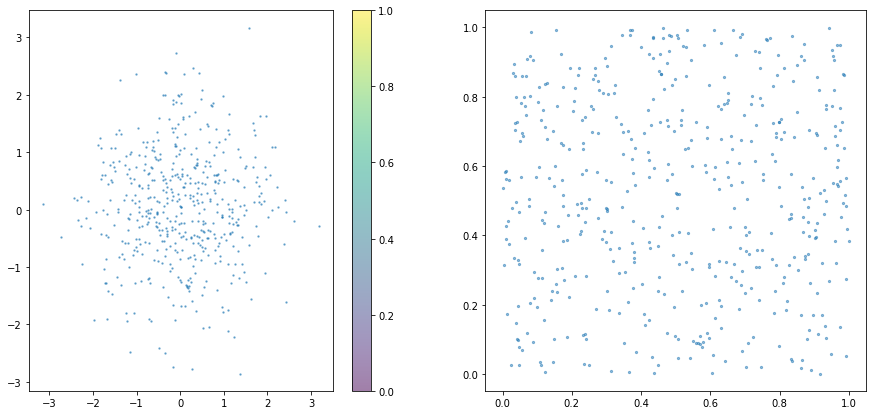

In [30]:
from scipy.stats import norm
n_to_show = 500
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test_reshape[example_idx]
example_labels = y_test[example_idx]

z_points = vae_sv.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
#plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels , alpha=0.5, s=2)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
#plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels, alpha=0.5, s=5)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , alpha=0.5, s=5)


plt.show()

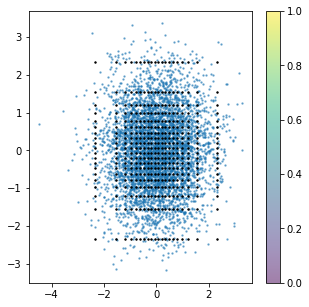

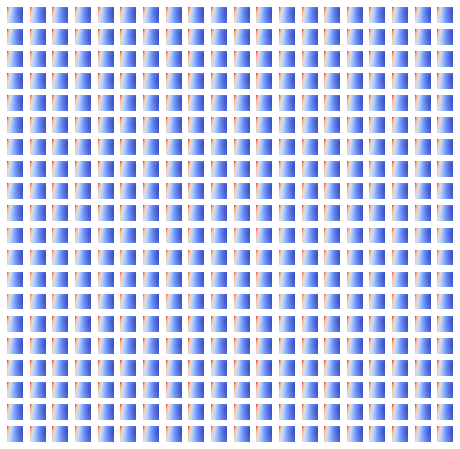

In [31]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test_reshape[example_idx]
example_labels = y_test[example_idx]

z_points = vae_sv.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' #, c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae_sv.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'coolwarm')